In [1]:
# 하나의 배치에서 베이스 네트워크를 학습하고
# 그것을 조건으로 서브 네트워크를 학습한다.
# 이때 서브 네트워크의 역전파가 베이스 네트워크의 인코더를 학습시키는가?
# 그때 베이스 네트워크의 디코더는 다시 학습할 필요가 있는가?(디코더만)

In [1]:
from myAE import Manager
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()

def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

In [3]:
from torch import nn
from collections import OrderedDict

class My_Encoder(nn.Module):
    def __init__(self, dim_input, dim_encoder_output=2, activation="tanh"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.l0 = nn.Linear(dim_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation="tanh"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

In [4]:
# make another network for 1 dimensionality and conditioned inputs
model = nn.Sequential(
    OrderedDict(
        [
            ("encoder", My_Encoder(784 + 2)), # with 2 condition -> mu and sigma out
            ("decoder", My_Decoder(3)),       # with 2 condition <- sample + 2
        ]
    )
)
optimizer = torch.optim.Adam(model.parameters())

In [5]:
from tqdm import tqdm

for _ in tqdm(range(30)):
    for x, y in manager.train_dataloader:

        # run base model
        h = manager.model.get_submodule("encoder")(x)
        mu = h[:, :2]
        log_sigma = h[:, 2:4]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu) * sigma + mu
        pred = manager.model.get_submodule("decoder")(z)
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        loss = ll + kl

        manager.optimizer.zero_grad()
        loss.backward()
        manager.optimizer.step()

        # get condition from the base model
        condition = manager.model.get_submodule("encoder")(x)[:, :2]
        
        # flatten the input data
        x_flat = x.view(len(x), -1)

        # concat the condition and data
        x_condi_flat = torch.cat([condition, x_flat], dim=1)

        # run encoder
        h = model.get_submodule('encoder')(x_condi_flat)

        # sampling
        mu = h[:, :1]
        log_sigma = h[:, 1:]
        sigma = log_sigma.exp()
        z = torch.rand_like(mu) * sigma + mu

        # concat the condition and sample point
        z_condi = torch.cat([condition, z], dim=1)

        # run decoder
        pred = model.get_submodule("decoder")(z_condi)

        # calc recon loss and kl divergence
        kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
        ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
        loss = ll + kl

        manager.optimizer.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        manager.optimizer.step()
        optimizer.step()

100%|██████████| 30/30 [09:57<00:00, 19.93s/it]


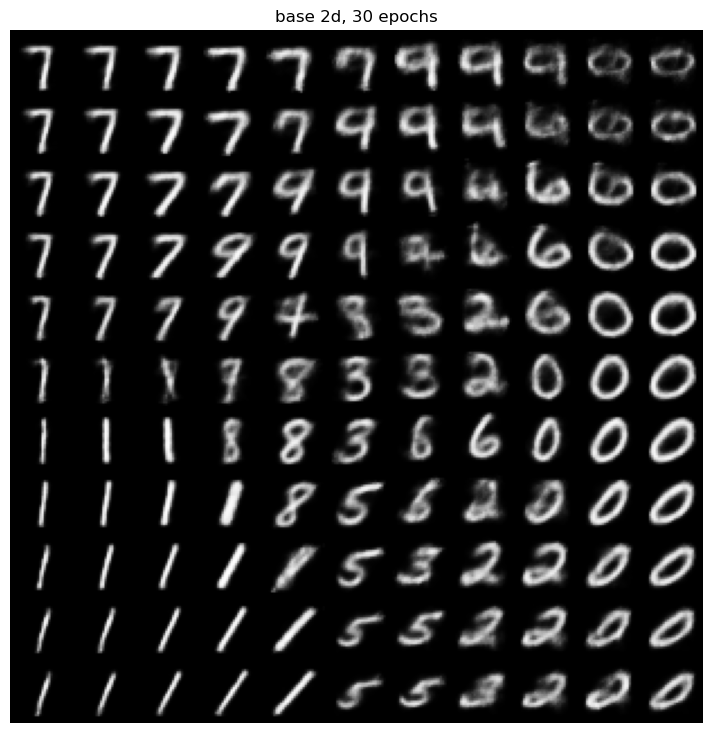

In [6]:
manager.plot_generated_images('base 2d, 30 epochs')

In [7]:
def get_tx(points):
    bases = []
    for p in points:
        bases.append(torch.ones(10, 1) * p)

    b = torch.linspace(-3, 3, 10).view(-1, 1)
    tx = torch.cat([*bases, b], dim=1)
    return tx


def show_ten_images(title, imgs):
    tmp = torch.zeros(28 * 10, 28)

    for idx, img in enumerate(imgs):
        tmp[idx * 28: (idx + 1) * 28, :28] = img.view(28, 28)
    
    plt.figure(figsize=(3, 15))
    plt.imshow(tmp, cmap='gray')
    plt.title(title, fontdict={'fontsize':20})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

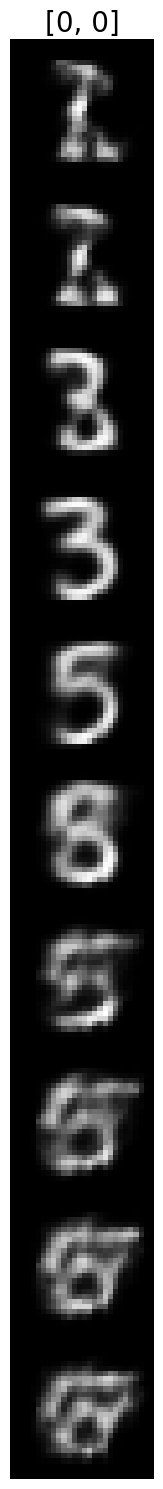

In [8]:
position = [0, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

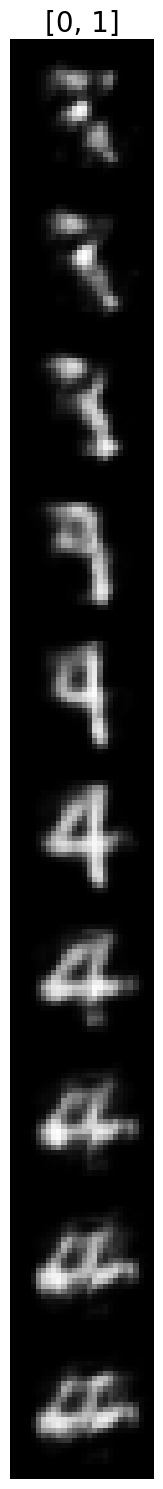

In [9]:
position = [0, 1]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

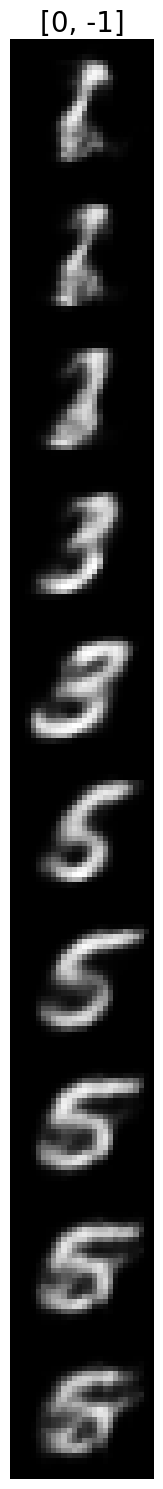

In [10]:
position = [0, -1]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

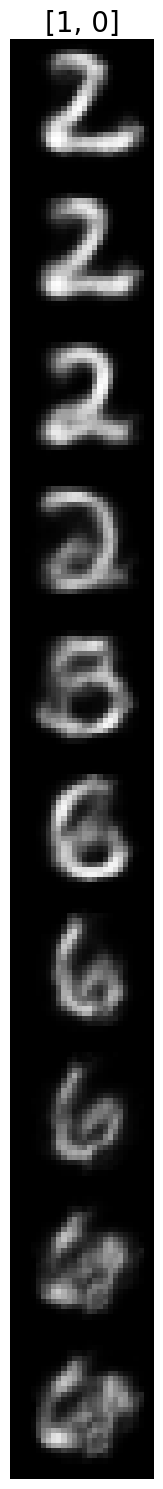

In [11]:
position = [1, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)

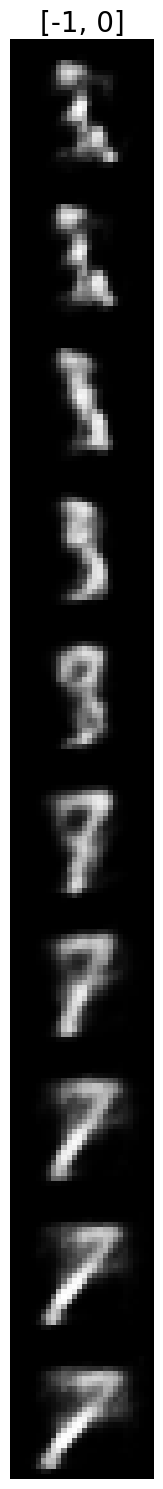

In [12]:
position = [-1, 0]

tx = get_tx(position)

with torch.no_grad():
    pred = model.get_submodule('decoder')(tx)

show_ten_images(str(position), pred)